# Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import os
from torch.utils.data import random_split
from PIL import Image
import pandas as pd
import numpy as np
import glob
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn

# People Dataset

In [18]:
RANDOM = 1
PERSON = 2

class People(Dataset):
  def __init__(self, root_dir, transform=None, loader=default_loader):
    
    self.image_paths, self.image_labels = self._get_imgs_and_labels(root_dir)
    
    self.transform = transform
    self.loader = loader
    
  def __len__(self):
    return len(self.image_labels)
  
  def __getitem__(self, index):
    image = self.loader(self.image_paths[index])
    label = self.image_labels[index]
    
    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
  
  # Helper Functions
  def print_image(self, index):
    img = Image.open(self.image_paths[index])
    
    img.show()

  def _get_imgs_and_labels(self, root_dir):
    image_full_path = []
    labels = []
    
    # Get the people images
    for img_path in glob.glob(os.path.join(root_dir, "People", "*.jpg")):
      image_full_path.append(img_path)
      labels.append(PERSON)
    
    # Get the random images
    for img_path in glob.glob(os.path.join(root_dir, "Random", "*.png")):
      image_full_path.append(img_path)
      labels.append(RANDOM)
      
    return image_full_path, labels


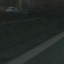

In [20]:
data_dir = "PeopleDataset"

data = People(root_dir=data_dir, transform=T.ToTensor())

data.print_image(2400)

# CNN

In [32]:
class Convolutional(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),                                                
    )
    self.linear = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(in_features=4608, out_features=4608),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=4608, out_features=2),
                                nn.Softmax()
                                )
  
  def forward(self, x):
    x = self.conv(x)
    b, c, h, w = x.shape
    x = x.view(b, -1) # Flatten image
    x = self.linear(x)
    
    return x

# Training

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([32, 3, 224, 224]), torch.Size([32])
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0])

tensor(0)
tensor(0)
tensor(0)


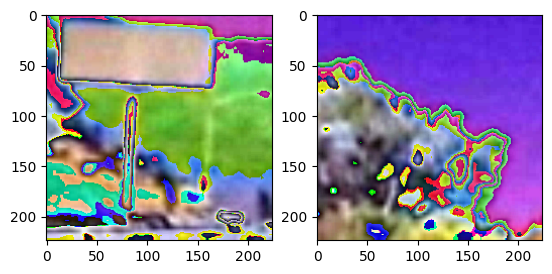

In [30]:
data_dir = "./PeopleDataset"

transform = T.Compose ([
  T.Resize((224, 224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

people_data = People(root_dir=data_dir, transform=transform)

train_data_size = int(len(people_data) * .7) 
validation_data_size = int(len(people_data) * .2)
test_size = len(people_data) - (train_data_size + validation_data_size)

train_data, val_data, test_data = random_split(people_data, [train_data_size, validation_data_size, test_size])

train = DataLoader(train_data, batch_size=32)
validation = DataLoader(val_data, batch_size=32)
test = DataLoader(test_data, batch_size=32)

data = iter(train) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

print(single_point[1][0])
print(single_point[1][1])
print(single_point[1][2])

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [38]:
loss_history=[]
vloss_history=[]
accuracy_history=[]
vaccuracy_history=[]

def train_model(optimizer,model,device,nepochs,LossFunction,batch_size,scheduler=None):
    # This is default on but let's just be pedantic
    model.train()
    loss = torch.Tensor([0])
    for epoch in tqdm(range(nepochs),
                    desc=f"Epoch",
                    unit="epoch",
                    disable=False):
        correct = 0
        total = 0
        for (data, label) in tqdm(train,
                                desc="iteration",
                                unit="%",
                                disable=True):
            optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
            
            # We need to make sure the tensors are on the same device as our model
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            loss.backward()
            optimizer.step()
            
            if (scheduler):
              scheduler.step()
            
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        
        accuracy = 100 * correct / total
        loss_history.append(loss.item())
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch}: loss: {loss.item()}, accuracy: {accuracy}")

In [34]:
def set_hyper_and_run(nepochs,LossFunction,batch_size,model,learning_rate,device,SGD=True):
    if SGD:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        # need to change learning rate to get Adam to converge
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=.2)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[2,4],gamma=0.4)
    print(model)
    train_model(optimizer=optimizer,model=model,device=device,nepochs=nepochs,LossFunction=LossFunction,batch_size=batch_size)

# HyperParameters
### Run Training Here

In [39]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

nepochs = 10
lf = nn.CrossEntropyLoss()  
batch_size = 32
model = Convolutional().to(device)
lr = .1

set_hyper_and_run(nepochs, lf, batch_size, model, lr, device)

Using GPU: NVIDIA GeForce RTX 2070 SUPER
Convolutional(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size

Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]/home/dlu/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch:  10%|█         | 1/10 [00:09<01:21,  9.08s/epoch]

Epoch 0: loss: 0.6360079646110535, accuracy: 55.4829838432451


Epoch:  20%|██        | 2/10 [00:17<01:09,  8.74s/epoch]

Epoch 1: loss: 0.4227849245071411, accuracy: 82.88071502234445


Epoch:  30%|███       | 3/10 [00:26<01:00,  8.63s/epoch]

Epoch 2: loss: 0.33780407905578613, accuracy: 92.02475077346168


Epoch:  40%|████      | 4/10 [00:34<00:51,  8.61s/epoch]

Epoch 3: loss: 0.3217354714870453, accuracy: 95.56548642145067


Epoch:  50%|█████     | 5/10 [00:43<00:43,  8.63s/epoch]

Epoch 4: loss: 0.3290119469165802, accuracy: 95.77174286696459


Epoch:  60%|██████    | 6/10 [00:52<00:34,  8.66s/epoch]

Epoch 5: loss: 0.3158302903175354, accuracy: 96.69989687177724


Epoch:  70%|███████   | 7/10 [01:00<00:26,  8.67s/epoch]

Epoch 6: loss: 0.32073479890823364, accuracy: 97.21553798556205


Epoch:  80%|████████  | 8/10 [01:08<00:17,  8.52s/epoch]

Epoch 7: loss: 0.31919026374816895, accuracy: 97.2842901340667


Epoch:  90%|█████████ | 9/10 [01:17<00:08,  8.50s/epoch]

Epoch 8: loss: 0.3181184232234955, accuracy: 97.35304228257134


Epoch: 100%|██████████| 10/10 [01:26<00:00,  8.60s/epoch]

Epoch 9: loss: 0.32854366302490234, accuracy: 97.35304228257134


In [44]:
model.eval()
accuracy = 0
for (data, label) in validation:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(val_data)*100:.2f}%")

/home/dlu/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Total accuracy = 98.07%
